<a href="https://colab.research.google.com/github/HR-HBM/BENG_BME-Project/blob/main/Project_Model_w_CLAHE_(ME_Detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib as plt

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
TRAIN_DIR = "/content/drive/MyDrive/MaculaEdema/train"
TEST_DIR = "/content/drive/MyDrive/MaculaEdema/test"
VAL_DIR = "/content/drive/MyDrive/MaculaEdema/validate"

In [31]:
train_datagen = ImageDataGenerator()

train_set = train_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224), batch_size=32, class_mode="categorical")

Found 4784 images belonging to 2 classes.


In [32]:
val_datagen = ImageDataGenerator()

val_set = train_datagen.flow_from_directory(VAL_DIR, target_size=(224, 224), batch_size=32, class_mode="categorical")

Found 579 images belonging to 2 classes.


In [38]:
import tensorflow as tf
import numpy as np
import cv2

class CLAHEPreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, clip_limit=3.0, tile_grid_size=(8, 8), **kwargs):
        super(CLAHEPreprocessingLayer, self).__init__(**kwargs)
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def call(self, inputs):
        # Use tf.numpy_function to apply CLAHE
        output = tf.numpy_function(self.apply_clahe, [inputs], tf.float32)

        # Explicitly set the shape to avoid unknown tensor shape issue
        output.set_shape(inputs.shape)  # Ensure it matches (None, 224, 224, 3)

        return output

    def apply_clahe(self, img_batch):
        processed_batch = []
        for img in img_batch:
            img = np.array(img, dtype=np.uint8)

            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Apply CLAHE
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=(8, 8))
            enhanced = clahe.apply(gray)

            # Convert back to 3-channel grayscale RGB
            enhanced_rgb = cv2.merge([enhanced, enhanced, enhanced])

            # Ensure output matches (224, 224, 3)
            enhanced_rgb = cv2.resize(enhanced_rgb, (224, 224))
            processed_batch.append(enhanced_rgb)

        return np.array(processed_batch, dtype=np.float32)

    def compute_output_shape(self, input_shape):
        return input_shape  # Ensures output matches input shape

In [39]:


IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.EfficientNetB1(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [40]:
model = tf.keras.Sequential([


  CLAHEPreprocessingLayer(),
  tf.keras.layers.Rescaling(1./255, input_shape=IMG_SHAPE),  # Normalize the image within the model
 # Apply CLAHE
  base_model,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='softmax')
])

print(model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ clahe_preprocessing_layer_7          │ ?                           │     0 (unbuilt) │
│ (CLAHEPreprocessingLayer)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_21 (Rescaling)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb1 (Functional)          │ (None, 7, 7, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,575,239 (25.08 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,575,239 (25.08 MB)

None


In [44]:
batch_size = 32
epochs = 3

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), #Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

history = model.fit(x=train_set, validation_data=val_set, batch_size=batch_size, epochs=epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(acc)
print(val_acc)

Epoch 1/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 741s 5s/step - accuracy: 0.4944 - loss: 0.6951 - val_accuracy: 0.1088 - val_loss: 0.7297
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 729s 5s/step - accuracy: 0.4839 - loss: 0.6951 - val_accuracy: 0.1088 - val_loss: 0.7051
Epoch 3/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 732s 5s/step - accuracy: 0.5126 - loss: 0.6934 - val_accuracy: 0.8912 - val_loss: 0.6845
[0.5016722679138184, 0.4945652186870575, 0.5087792873382568]
[0.10880828648805618, 0.10880828648805618, 0.8911917209625244]


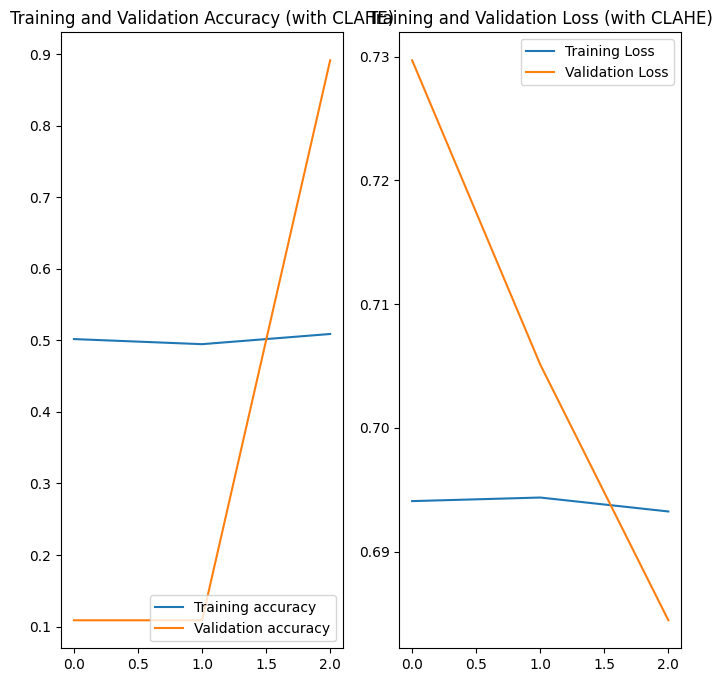

In [45]:
epochs_range = range(len(acc))
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy (with CLAHE)")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss (with CLAHE)")

plt.show()

In [46]:
model.save("/content/drive/MyDrive/MaculaEdema/MaculaEdema-wCLAHE.h5")